In [1]:
include("../lna.jl")
using DifferentialEquations, StatsBase, Plots, Distributions, LaTeXStrings, DataFrames, CSV

# Setup

In [196]:
function reaction(n)
    "
    ρ_m$(n), 0 --> M$(n)
    δ_m$(n), M$(n) --> 0
    σ_b$(n), M$(n) + R --> MR$(n)
    δ_u$(n), MR$(n) --> M$(n) + R
    ρ_p$(n), MR$(n) --> M$(n) + P$(n) + R
    δ_mr$(n), MR$(n) --> 0
    δ_p$(n), P$(n) --> 0
    "
end

function endstring(n)
    cumulative_string = "end ρ_r δ_r "
    for i in 1:n
        cumulative_string = string(cumulative_string, "ρ_m$(i) δ_m$(i) σ_b$(i) δ_u$(i) ρ_p$(i) δ_mr$(i) δ_p$(i) ")
    end
    cumulative_string
end

function generate_rn(n)
    rnstring = "rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    "
    for i in 1:n
        rnstring = string(rnstring, reaction(i))
    end
    rnstring = string(rnstring, endstring(n))
    print(rnstring)
    rnexpression = Base.Meta.parse(rnstring)
    eval(rnexpression)
end

function generate_propensities(n)
    rand(Float64, (6*n+2))
end

function relative_error(true_val, approx_val)
    map(abs, 1 .- approx_val./true_val)
end

# Valid always
function FF_single_gene_ribosome(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5] - props[6] + props[7] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx(props)
    k1 = props[3]
    k2 = props[4]
    k3 = props[5]/props[6] + props[7]/ props[8] # What should this really be?
    k6 = props[2]
    k7 = props[1]
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end

function FF_single_gene_ribosome_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*(k2+k6))+k1*k3/(2*k2*k6)
end

# Valid if k2>>k6
function FF_single_gene_ribosome_approx_sim(props, p)
    k1 = props[3]
    k2 = props[4]
    k6 = props[2]
    k7 = props[1]
    k3 = p*k6*k2*k6/(k1*k7)
    return 1 + k3*k7/(k6*k2)+k1*k3/(2*k2*k6)
end


FF_single_gene_ribosome_approx_sim (generic function with 1 method)

# Verifying the LNA solution

In [21]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(ps, [1.5, .1, .2, .1, .5, .1])
end

prob = LNAProblem(rn, zeros(Int, 3*N+1), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 1000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)

protein_counts = map(x -> x[4], sol.u)

1000001-element Vector{Int64}:
 15
 14
 16
 14
 11
 10
 11
 11
 12
 14
 12
 12
 12
  ⋮
  9
  8
  9
 12
 13
 14
 15
 16
 14
 12
 15
 14

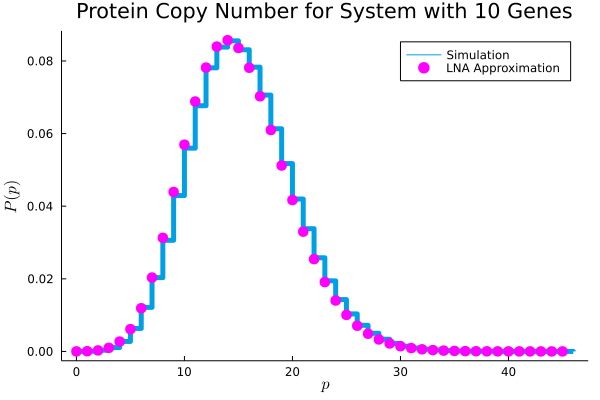

In [22]:
histogram(protein_counts, nbins=maximum(protein_counts), norm=true, label="Stochastic Simulation Algorithm")

prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    title = "Protein Copy Number for System with $N Genes", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [23]:
savefig("../../data/figures-for-paper/protein_copy_number_$(N)_genes.svg")

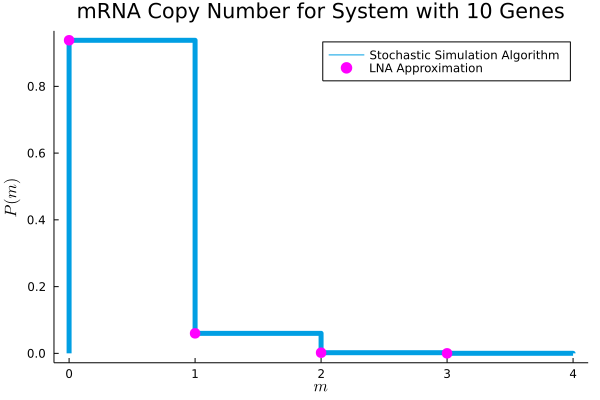

In [24]:
mrna_counts = map(x -> x[2], sol.u)
histogram(mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Stochastic Simulation Algorithm",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

m_mean = lnameans[2]
m_var = lnacovs[2,2]

p = m_mean/m_var
r = m_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
xs = [0:1:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)
scatter!(
    xs,
    ys,
    label="LNA Approximation", 
    title = "mRNA Copy Number for System with $(N) Genes",
    xlabel=L"m",
    ylabel=L"P(m)",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false
)

In [25]:
savefig("../../data/figures-for-paper/mrna_copy_number_$(N)_genes.svg")

# Comparison of Full and Reduced Models

In [40]:
xs = 1:10:100
ffs_full = zeros(length(xs))
ffs_red = zeros(length(xs))
ffs_red_approx = zeros(length(xs))

for i in 1:length(xs)
    N = xs[i]
    rn = generate_rn(N)

    ps = [50., .1]

    for j in 1:N
        ps = vcat(ps, [1.5, .1, .2, .1, .5, .1])
    end

    prob = LNAProblem(rn, zeros(Int, 3*N+1), ps)

    sol = solve(prob)

    lnameans = mean(sol)
    lnacovs = StatsBase.cov(sol)

    ffs_full[i] = lnacovs[4,4]/lnameans[4]
    ffs_red[i] = FF_single_gene_ribosome_sim(ps, lnameans[4])
    ffs_red_approx[i] = FF_single_gene_ribosome_approx_sim(ps, lnameans[4])
end

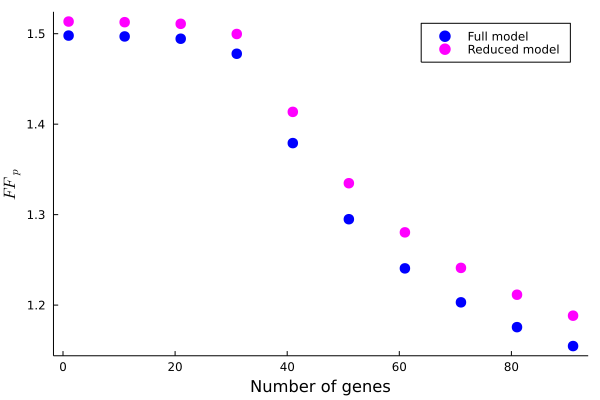

In [41]:
scatter(
    xs,
    ffs_full,
    label="Full model",
    markersize=6,
    markercolor=RGBA(0/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(0/255, 0/255, 255/255, 255/255),
)

scatter!(
    xs,
    ffs_red,
    label="Reduced model",
    xlabel="Number of genes",
    ylabel=L"FF_{p}",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false)

In [42]:
savefig("../../data/figures-for-paper/full_model_verses_reduced_model_$(N)_genes.svg")

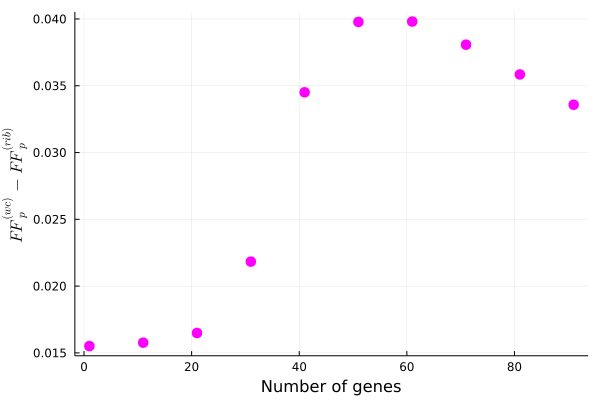

In [53]:
scatter(
    xs,
    ffs_red-ffs_full,
    ylabel=L"FF_p^{(wc)} - FF_p^{(rib)}",
    xlabel="Number of genes",
    markersize=6,
    markercolor=RGBA(255/255, 0/255, 255/255, 255/255),
    markershape=:circle,
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    legend=false
)

In [54]:
savefig("../../data/figures-for-paper/residuals_full_model_ribosome_model_$(N)_genes.svg")

# Choosing Realistic Parameters

In [60]:
# Load data from schwannhauser
exp_data = DataFrame(CSV.File("../../data/experimental_data_sanitised.csv"))
dropmissing!(exp_data)
names(exp_data)

7-element Vector{String}:
 "id"
 "pNumber"
 "mNumber"
 "alpha"
 "beta"
 "mHalfLife"
 "pHalfLife"

In [64]:
median(df[!, :pNumber])

41913.32

In [65]:
mean(df[!, :pNumber])

475168.0025453261

In [86]:
sort(df, [:pNumber])[50, :]

,id,pNumber,mNumber,alpha,beta,mHalfLife,pHalfLife
,String,Float64,Float64,Float64,Float64,Float64,Float64
50,IPI00136246.1,343.98,17.43,2.0,1.57,8.54,39.97


In [198]:
N = 10

rn = generate_rn(N)

ps = [50., .1]
    
for i in 1:N
    ps = vcat(
        ps, 
        [
            1.9, # mRNA creation
            log(2)/8.54, # mRNA degredation
            .01, # binding to polysome
            0.001, # unbinding from polysome
            5.0, # translation,
            .1, # monosome decay
            .1 # protein decay
        ]
    )
end


prob = LNAProblem(rn, zeros(Int, 3*N+3), ps)

sol = solve(prob)

lnameans = mean(sol)
lnacovs = StatsBase.cov(sol)

initial_values = map(Int64, map(ceil, lnameans))

prob = DiscreteProblem(rn, initial_values, (0, 10000000.),  ps)
jump_prob = JumpProblem(rn, prob, Direct(), save_positions=(false, false))

sol = solve(jump_prob, SSAStepper(), saveat=1.0)
mrna_counts = map(x -> x[2], sol.u)
monosome_counts = map(x -> x[3], sol.u)
protein_counts = map(x -> x[4], sol.u)
ribosome_counts = map(x -> x[1], sol.u)

print("
    mRNA counts: $(mean(mrna_counts + monosome_counts))\n
    unbound mRNA counts: $(mean(mrna_counts))\n
    protein counts: $(mean(protein_counts))\n
    ribosomes counts: $(mean(ribosome_counts))\n
    ")

rn = @reaction_network begin
        ρ_r, 0 --> R
        δ_r, R --> 0
    
    ρ_m1, 0 --> M1
    δ_m1, M1 --> 0
    σ_b1, M1 + R --> MR1
    δ_u1, MR1 --> M1 + R
    ρ_p1, MR1 --> M1 + P1 + R
    δ_mr1, MR1 --> 0
    δ_p1, P1 --> 0
    
    ρ_m2, 0 --> M2
    δ_m2, M2 --> 0
    σ_b2, M2 + R --> MR2
    δ_u2, MR2 --> M2 + R
    ρ_p2, MR2 --> M2 + P2 + R
    δ_mr2, MR2 --> 0
    δ_p2, P2 --> 0
    
    ρ_m3, 0 --> M3
    δ_m3, M3 --> 0
    σ_b3, M3 + R --> MR3
    δ_u3, MR3 --> M3 + R
    ρ_p3, MR3 --> M3 + P3 + R
    δ_mr3, MR3 --> 0
    δ_p3, P3 --> 0
    
    ρ_m4, 0 --> M4
    δ_m4, M4 --> 0
    σ_b4, M4 + R --> MR4
    δ_u4, MR4 --> M4 + R
    ρ_p4, MR4 --> M4 + P4 + R
    δ_mr4, MR4 --> 0
    δ_p4, P4 --> 0
    
    ρ_m5, 0 --> M5
    δ_m5, M5 --> 0
    σ_b5, M5 + R --> MR5
    δ_u5, MR5 --> M5 + R
    ρ_p5, MR5 --> M5 + P5 + R
    δ_mr5, MR5 --> 0
    δ_p5, P5 --> 0
    
    ρ_m6, 0 --> M6
    δ_m6, M6 --> 0
    σ_b6, M6 + R --> MR6
    δ_u6, MR6 --> M6 + R
    ρ_p6, MR6 --> M6 

In [199]:
mean(mrna_counts + monosome_counts)

21.220799977920002

In [200]:
mean(mrna_counts)

11.821409617859038

In [201]:
mean(protein_counts)

470.0442120955788

In [202]:
mean(ribosome_counts)

405.905749609425

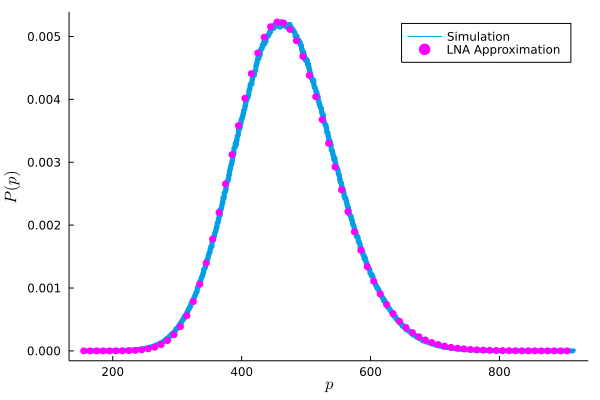

In [212]:
prot_mean = lnameans[4]
prot_var = lnacovs[4,4]

p = prot_mean/prot_var
r = prot_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(protein_counts):step:maximum(protein_counts)]
ys = Distributions.pdf(nb, xs)

histogram(
    protein_counts, 
    nbins=maximum(protein_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"p", 
    ylabel=L"P(p)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [213]:
savefig("../../data/figures-for-paper/protein_count_$(N)_genes_IPI00136246.svg")

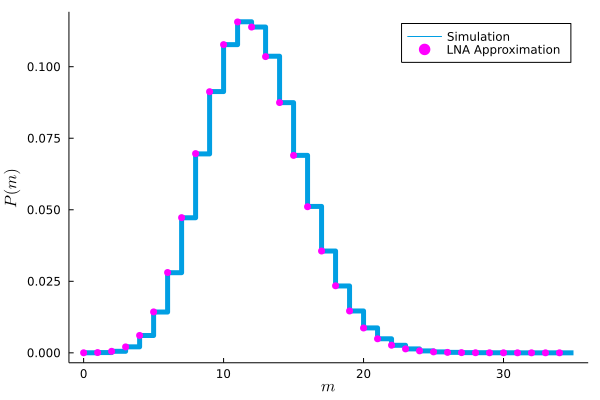

In [219]:
mrna_mean = lnameans[2]
mrna_var = lnacovs[2,2]

p = mrna_mean/mrna_var
r = mrna_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 1
xs = [minimum(mrna_counts):step:maximum(mrna_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    mrna_counts, 
    nbins=maximum(mrna_counts), 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"m", 
    ylabel=L"P(m)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)

In [220]:
savefig("../../data/figures-for-paper/mrna_count_$(N)_genes_IPI00136246.svg")

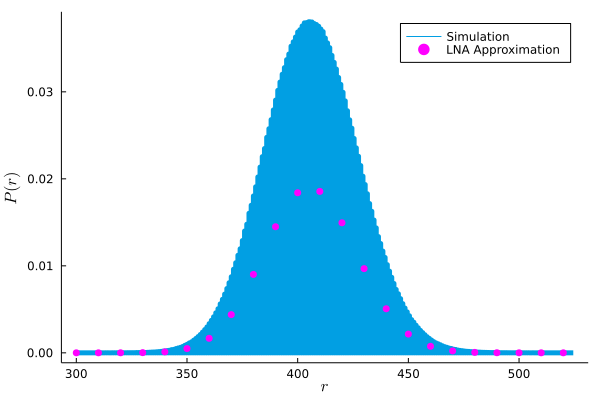

In [225]:
rib_counts = ribosome_counts
rib_mean = lnameans[1]
rib_var = lnacovs[1,1]

p = rib_mean/rib_var
r = rib_var*p^2/(1-p)

nb = NegativeBinomial(r,p)
step = 10
xs = [minimum(rib_counts):step:maximum(rib_counts)]
ys = Distributions.pdf(nb, xs)


histogram(
    rib_counts, 
    nbins=300, 
    norm=true, 
    label="Simulation",
    linewidth=5,
    color=RGBA(0/255, 159/255, 227/255, 254/255)
)

scatter!(
    xs,
    ys, 
    label="LNA Approximation", 
    xlabel=L"r", 
    ylabel=L"P(r)",
    color = RGBA(255/255, 0/255, 255/255, 255/255),
    markerstrokecolor=RGBA(255/255, 0/255, 255/255, 255/255),
    grid=false,
    markersize=4
)